# Generating a phantom and a sinogram

- Generate a phantom where each pixel consists of part bone and part water described as (bone, water)
    - Background values should be low for both to simulate air (0, 0.05)
    - main body should be elliptical and mainly consist of water (0.20, 0.80)
    - elliptical inserts should simulate different organs and/or body featurs (0.80, 0.80)

- Generate a sinogram from the projections
    - The function will return a 3D object containing the sinograms for the height of the detector. We want to select a slice to display
    - print a 2D cross section of the phantom with a corresponding sinogram

In [26]:
#settings
objectSize = 32     # size of the object
nPixelsY = 64       # number of pixels in Y direction detector
nPixelsZ = 44       # number of pixels in Z direction detector
projections = 64    # number of projections
iterations = 40     # number of iterations

## generate phantom

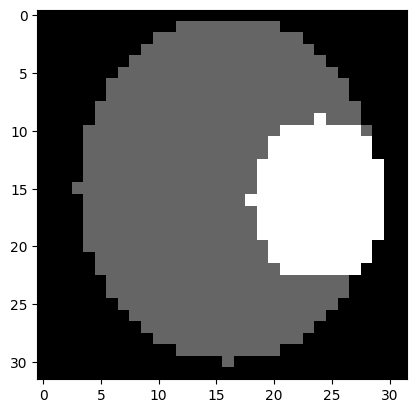

In [34]:
#| label: generate_phantom

import random, numpy as np

def generate_phantom(n, h, num_features=1):

    h = random.randint(1, 3)  # Random height offset for the torso

    # Initialize 3D bone and water matrices with zeros
    bone_matrix = np.zeros((n, n, n), dtype=float)
    water_matrix = np.zeros((n, n, n), dtype=float)

    # fill background of matrices with 0.05 bone and water 
    bone_matrix.fill(0.05)
    water_matrix.fill(0.05)
    
    # set values for main ellipse (simulated torso)
    intensity_bone = random.uniform(0.1, 0.6)
    intensity_water = random.uniform(0.1, 0.6)  # Random intensity for water
    
    offset_i = np.random.randint(-h, h + 1)
    offset_j = np.random.randint(-h, h + 1)

    center_i = n // 2 + offset_i
    center_j = n // 2 + offset_j

    # Main body ellipse (simulated torso with random offset)
    for i in range(h, n - h):
        for j in range(2 * h, n - 2 * h):
            if ((i - center_i) / ((n - 2 * h) / 2)) ** 2 + ((j - center_j) / ((n - 6 * h) / 2)) ** 2 <= 1:
                bone_matrix[2*h:-2*h, i, j] = intensity_bone
                water_matrix[2*h:-2*h, i, j] = intensity_water

    # Adding smaller features (e.g., organs or bone structures)
    for _ in range(num_features):
        
        # Random place in the body - h is the offset from the edge, n is the size of the matrix
        a = random.randint(h, (n - h) // 4)  # Semi-major axis
        b = random.randint(h, (n - h) // 4)  # Semi-minor axis
        center_x = random.randint(h + a, n - h - a)
        center_y = random.randint(3 * h + b, n - 3 * h - b)

        a_water = random.randint(h, (n - h) // 4)  # Semi-major axis for water
        b_water = random.randint(h, (n - h) // 4)  # Semi-minor axis for water

        # Randomly choose the intensity for bone and water, together they add to 1. 
        bone_intensity = 0.8
        water_intensity = 0.8
        
        for i in range(center_x - a_water, center_x + a_water):
            for j in range(center_y - b_water, center_y + b_water):
                if 0 <= i < n and 0 <= j < n:
                    if ((i - center_x) / a_water) ** 2 + ((j - center_y) / b_water) ** 2 <= 1:
                        bone_matrix[2*h:-2*h, i, j] = bone_intensity

        center_x = random.randint(h + a, n - h - a)
        center_y = random.randint(3 * h + b, n - 3 * h - b)
                        
        for i in range(center_x - a, center_x + a):
            for j in range(center_y - b, center_y + b):
                if 0 <= i < n and 0 <= j < n:
                    if ((i - center_x) / a) ** 2 + ((j - center_y) / b) ** 2 <= 1:
                        water_matrix[2*h:-2*h, i, j] = water_intensity

    water_matrix *= 1  # Water density is 1
    bone_matrix *= 1.92  # Apply bone density
    
    return bone_matrix, water_matrix

bone, water = generate_phantom(objectSize, 2, num_features=1)
x = np.column_stack((bone.ravel(), water.ravel()))

# show phantom for bone
plt.imshow(bone[objectSize // 2, :, :], cmap='gray')
plt.show()

## Running projection algorithm

In [35]:
from libs.simulatepreps import projectMatrix

#generate proection matrices
y, S, M, A = projectMatrix(x, objectSize, nPixelsY, nPixelsZ, 1, projections)

## Generating sinogram

In [36]:
def getSinogram(y, energy_bin_index=0, z_index=32, nProj=100, detector_shape=(64, 44)):  
    nX, nZ = detector_shape
    y_bin = y[energy_bin_index]
    y_proj_zx = y_bin.reshape((nProj, nZ, nX))  # shape: (100, 64, 44)
    sinogram = y_proj_zx[:, z_index, :]  # shape: (100, 44)
    return sinogram

sinogram = getSinogram(y, energy_bin_index=0, z_index=objectSize // 2, nProj=projections, detector_shape=(nPixelsY, nPixelsZ))


## Make figure

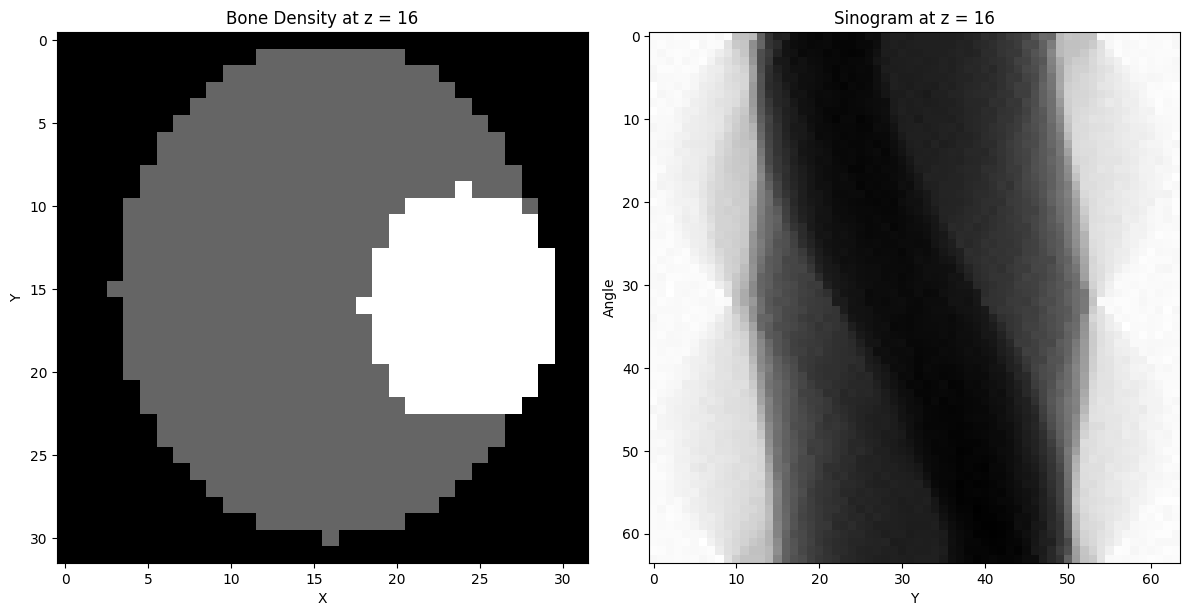

In [37]:
#| label: phantomAndSinogram

import matplotlib.pyplot as plt


# plot bone density and phantom at objectSize //2 
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(bone[objectSize // 2, :, :], cmap='gray')
plt.title('Bone Density at z = {}'.format(objectSize // 2))
plt.xlabel('X')
plt.ylabel('Y')

plt.subplot(1, 2, 2)
plt.imshow(sinogram, cmap='gray')
plt.title('Sinogram at z = {}'.format(objectSize // 2))
plt.ylabel('Angle')
plt.xlabel('Y')

plt.tight_layout()
plt.show()

# Visualising a 2D convolution

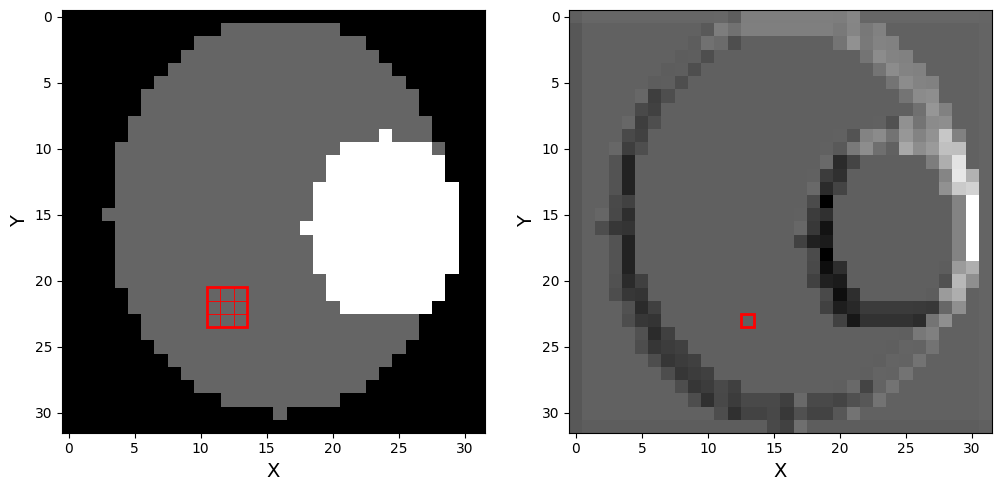

In [42]:
#| label: convolutionExample
# we want to put the phantom through a pytorch 2d convolution layer
import torch

bone_array = bone[objectSize // 2, :, :]
bone_tensor = torch.tensor(bone[objectSize // 2, :, :], dtype=torch.float32)

# create a 2D convolution layer with a kernel size of 3x3
conv_layer = torch.nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding=1)

# apply the convolution layer to the bone tensor
output_tensor = conv_layer(bone_tensor.unsqueeze(0).unsqueeze(0))  # Add batch and channel dimensions
output_image = output_tensor.squeeze(0).squeeze(0).detach().numpy()  # Remove batch and channel dimensions

# plot 2 plots, one of the original bone image with a square showing one of the convolution kernels, and next to it the output image
plt.figure(figsize=(12, 6))
#make sure xlabel and ylabel are larger
plt.rcParams['axes.labelsize'] = 14
plt.subplot(1, 2, 1)
plt.imshow(bone_tensor.numpy(), cmap='gray')
# draw a square representing the convolution kernel
kernel_size = conv_layer.kernel_size[0]
plt.gca().add_patch(plt.Rectangle((10.5, 20.5), kernel_size, kernel_size, edgecolor='red', facecolor='none', lw=2))
# fill square with rectengles for each pixel
for i in range(kernel_size):
    for j in range(kernel_size):
        plt.gca().add_patch(plt.Rectangle((10.5 + i, 20.5 + j), 1, 1, edgecolor='red', facecolor='none', lw=0.5))
plt.xlabel('X')
plt.ylabel('Y')
plt.subplot(1, 2, 2)
plt.imshow(output_image, cmap='gray')
# draw little square representing the pixel on which the convolution was applied
plt.gca().add_patch(plt.Rectangle((10.5+2, 20.5+2), 1, 1, edgecolor='red', facecolor='none', lw=2))
plt.xlabel('X')
plt.ylabel('Y')
plt.show()